In [2]:
#math and linear algebra stuff
import numpy as np

#plots
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15.0, 15.0)
#mpl.rc('text', usetex = True)
import matplotlib.pyplot as plt
%matplotlib inline

# Orthonormalization process
This notebooks exposes how to perform orthogonalization on a set of vector, such that the resulting method is fast and accurate.

## Orthonormalization through Gram-Schmidt

The gram-schmidt process is the most reknown method to orthogonormalize a set of vector, see [this page](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process).

The idea, is to loop over the set of vector $\{\vec{v_0}, \vec{v_1}, \dots, \vec{v_{n-1}} \}$, project (by the mean of a simple dot product) each new vector $\vec{v_k}$ onto the set of previously orthonormalized vector $\{\vec{e_0}, \vec{e_1}, \dots, \vec{e_{k-1}} \}$ that one can substract the linearly dependent components:

\begin{align*}
  \vec{e_k'} = \vec{v_k} - \sum_{i=0}^{k-1} \left( \vec{v_k} \cdot \vec{e_i} \right)  \vec{e_i}
\end{align*}


Once $\vec{e_k'}$ is built, one can normalize it : $\vec{e_k}=\frac{\vec{e_k'}}{\|\vec{e_k'}\|}$

In [4]:
"""
Gram-Schmidt method for basis orthonormalization
"""
size = 25
nbVec = 15
V = np.random.rand(size,nbVec)

#Naive orthogonalization loop
for i in np.arange(nbVec):
  #get current vector
  ek=V[:,i]
  if i>0:
    #Compute projection onto other vector
    proj = np.dot(ek,V[:,:i])
    #orthogonalize
    ek = ek - np.dot(V[:,:i], proj)
  #Normalize vector and update V
  V[:,i] = ek / np.sqrt(np.dot(ek,ek))

#check that V is orthonormal
assert( np.allclose(np.identity(nbVec),np.dot(V.T,V)) )

## Orthogonalization using Gram matrix and Choleski

Another possible solution is based on the Gram matrix $M_G$ of the set of vectors $\{\vec{v_0}, \vec{v_1}, \dots, \vec{v_{n-1}} \}$, computed as $M_G(i,j)= \langle \vec{v_i}, \vec{v_j} \rangle$

The gram matrix is a symmetric, positive semidefinite matrix, whose entries are actually all computed during the Gram-Schmidt process, however, at a high, level, one can compute $M_G=V^t V$ with a single matrix-matrix multiplication.

The interesting part is what happens next. Indeed, one can see, that orthogonalizing a set of vector, amounts to make its gram matrix a diagonal matrix, which can be obtained by using either the eigendecomposition:

\begin{align*}
  M_G &= V^t V\\
  Q D Q^t &= V^t V \\
  D &= Q^t V^t V Q \\
  D &= (V Q)^t (V Q)
\end{align*}

Orthonormalizing a set of vector, amounts to make its gram matrix equal to the identity matrix, which can be obtained by using  its factorization as a product of square root of $M_G$:

\begin{align*}
  M_G &= V^t V\\
  M_G^{\frac{1}{2}t} M_G^{\frac{1}{2}} &= V^t V\\
  I &= M_G^{-\frac{1}{2}t} V^t V M_G^{-\frac{1}{2}}\\
  I &= (V M_G^{-\frac{1}{2}})^t (V M_G^{-\frac{1}{2}})
\end{align*}

Such that $(M_G^{\frac{1}{2}} V)$ is the new orthonormalized set of vector. Now, we are interested in finding, either

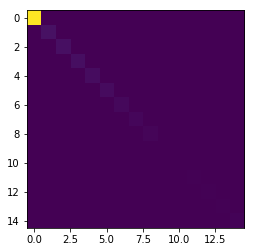

In [13]:
"""
Eigen method for basis orthogonalization
"""
size = 25
nbVec = 15
V = np.random.rand(size,nbVec)

#Compute Gram matrix
Mg = np.dot(V.T,V)

#Perform eigendecomposition
D,Q=np.linalg.eig(Mg)

#Compute Mg2 with the modified vectors V2
V2 = np.dot(V,Q)
Mg2 = np.dot(V2.T,V2)

#check that Mg2 is orthonormal
assert( np.allclose(Mg2-Mg2*np.identity(nbVec),np.zeros((nbVec,nbVec))) )

#Show matrix Mg2
plt.imshow(Mg2,interpolation='none')

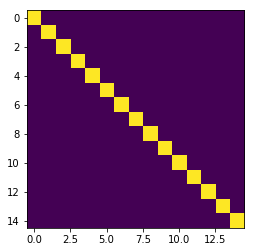

In [15]:
"""
Choleski method for basis orthonormalization
"""
size = 25
nbVec = 15
V = np.random.rand(size,nbVec)

#Compute Gram matrix
Mg = np.dot(V.T,V)

#Perform Choleski factorization
L=np.linalg.cholesky(Mg)

#Compute Mg2 with the modified vectors V2
V2 = np.dot(V,np.linalg.inv(L.T))
Mg2 = np.dot(V2.T,V2)

#check that Mg2 is orthonormal
assert( np.allclose(Mg2-Mg2*np.identity(nbVec),np.zeros((nbVec,nbVec))) )

#Show matrix Mg2
plt.imshow(Mg2,interpolation='none')

## Remark
It should be noticed that a Gram matrix is always symmetric positive semi difinite, and as such can be diagonalized in an orthonormal basis, which makes $Q^t$ the inverse of $Q$.

In the Choleski case, it should be noticed that computing the inverse of a lower triangular matrix is a low complexity operation. Demonstration sketch is as follow:
Let $L$ be a lower triangular matrix of size n, we have $L=D(I+N)$, where D is a diagonal matrix, I is the identity matrix, and N is a strictly lower triangular matrix.
As such, N is n-nilpotent, ie $N^n=0$, and, using the taylor development:

\begin{align*}
  (I-N)^{-1} &= \sum_{i=0}^{n-1} N^i \\
  (I+N)^{-1} &= \sum_{i=0}^{n-1} (-1)^i N^i
\end{align*}

We can compute $L^{-1}=(I+N)^{-1} D^{-1}$ quite easily with matrix exponentiation, or just by noticing that inverse of a upper/lower triangular matrix $L$ can be computed by forward/backward subsitution.
In the framework of high performance computing, one may be interested in using dtrtri, the level 3 BLAS Triangular Matrix Inversion (TMI).

## Generalizes of orthogonal decomposition from linear spaces to convex cones: Moreau's decomposition

Main source for this analysis can be found there:
https://www.convexoptimization.com/wikimization/index.php/Convex_cones
https://www.convexoptimization.com/wikimization/index.php/Moreau's_decomposition_theorem